## ANOMALY DETECTION USING ISOLATION FOREST & LOCAL OUTLIER FACTOR

### INDUSTRY : CREDIT CARD

- As per industry report Fraud Detection & Prevention Market was approx. $20Billion in 2018  and  will be $63.5Billion by 2023, at a Compound Annual Growth Rate (CAGR) of 26.7%

#### Major challenges in Building Fraud Model: -

1. Imbalanced Class Data – On an average, only 1-2% of total transactions is identified as fraud which one of the biggest challenges for data scientist to build robust model to identify transactions.

2. Labelled Data – Non availability of labelled data as legitimate or fraud. Most of time data at organization level is not labelled or small amount of labelled data and labelling them is tedious and cost.

3. Sometimes the fraud actives are mixed up with the normal activities, hard to identify using general algorithms

4. Fraudlent activities (in case of few reported incidents) tend to change their mode of transaction and process

![anomaly-detection-using-machine-learning-and-deep-learning](https://user-images.githubusercontent.com/54467567/87521003-5fc6d580-c649-11ea-90ef-e6fc8775f558.jpg)

In [2]:
# LIBRARIES 

import pandas as pd
import os
import numpy as np
import pandas_profiling
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import datasets
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn import svm
from sklearn.neighbors import NearestNeighbors

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import datetime

from bokeh.models import ColumnDataSource
from bokeh.models import SaveTool
from bokeh.models import HoverTool
from bokeh.palettes import RdBu3
from bokeh.plotting import figure,output_file,show
from bokeh.io import output_notebook,show
output_notebook()

%matplotlib inline
pd.set_option('display.max_columns', None)
os.chdir(r"D:\New_files\Github\Fraude-detection---PySpark-SparkSQL-master\310_23498_bundle_archive")

C:\Users\Thatoi\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Loading BokehJS ...

#### CREDIT CARD FRADULENT DATA
Kaggle : https://www.kaggle.com/mlg-ulb/creditcardfraud

In [3]:
# MEMORY OPTIMIZATION

def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [4]:
def byte_decoder(val):
    # decodes byte literals to strings
    
    return val.decode('utf-8')

In [5]:
def plot_confusion_matrix(cm, title, classes=['abnormal', 'normal'],
                          cmap=plt.cm.Blues, save=False, saveas="MyFigure.png"):
    
    # print Confusion matrix with blue gradient colours
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.1%'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if save:
        plt.savefig(saveas, dpi=100)

In [6]:
def plot_gridsearch_cv(results, estimator, x_min, x_max, y_min, y_max,save=False, saveas="MyFigure.png"):
    
    # print GridSearch cross-validation for parameters
    
    plt.figure(figsize=(10,8))
    plt.title("GridSearchCV for "+estimator, fontsize=24)

    plt.xlabel(estimator)
    plt.ylabel("Score")
    plt.grid()

    ax = plt.axes()
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    pad = 0.005
    X_axis = np.array(results["param_"+estimator].data, dtype=float)

    for scorer, color in zip(sorted(scoring), ['b', 'k']):
        for sample, style in (('train', '--'), ('test', '-')):
            sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
            sample_score_std = results['std_%s_%s' % (sample, scorer)]
            ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
            ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

        best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
        best_score = results['mean_test_%s' % scorer][best_index]

        # Plot a dotted vertical line at the best score for that scorer marked by x
        ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

        # Annotate the best score for that scorer
        ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score+pad))

    plt.legend(loc="best")
    plt.grid('off')
    plt.tight_layout()
    if save:
        plt.savefig(saveas, dpi=100)
        
    plt.show()

In [28]:
# DATA INGESTION

data = pd.read_csv('creditcard.csv')
data_opt = reduce_mem_usage(data)
data_opt.head()

data_opt['Class']=data_opt.Class
anomaly_rate = 1.0 - len(data_opt.loc[data_opt['Class']==0])/len(data_opt)


print(data_opt.head(),
"Anomaly Rate is:"+"{:.1%}".format(anomaly_rate))

Memory usage of dataframe is 67.36 MB
Memory usage after optimization is: 17.11 MB
Decreased by 74.6%
   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359375 -0.072754  2.537109  1.377930 -0.338379  0.462402  0.239624   
1   0.0  1.191406  0.266113  0.166504  0.448242  0.060028 -0.082336 -0.078796   
2   1.0 -1.358398 -1.339844  1.773438  0.379883 -0.503418  1.800781  0.791504   
3   1.0 -0.966309 -0.185181  1.792969 -0.863281 -0.010307  1.247070  0.237549   
4   2.0 -1.158203  0.877930  1.548828  0.403076 -0.407227  0.095947  0.592773   

         V8        V9       V10       V11       V12       V13       V14  \
0  0.098694  0.363770  0.090820 -0.551758 -0.617676 -0.991211 -0.311279   
1  0.085083 -0.255371 -0.166992  1.612305  1.065430  0.489014 -0.143799   
2  0.247681 -1.514648  0.207642  0.624512  0.066101  0.717285 -0.165894   
3  0.377441 -1.386719 -0.054962 -0.226440  0.178223  0.507812 -0.287842   
4 -0.270508  0.817871  0.752930 -0.8

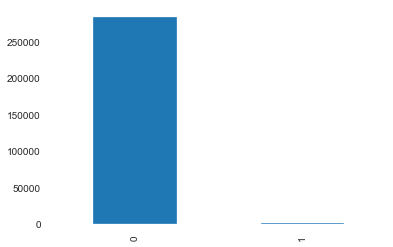

In [29]:
# TARGET DISTRIBUTION

data_opt['Class'].value_counts().plot(kind='bar');

#### TRAIN & TEST SPLIT

In [30]:
data_opt['target'] = [1 if x == 0 else -1 for x in data_opt['Class']]
X_train_sa, X_test_sa, y_train_sa, y_test_sa = train_test_split(data_opt.drop(['Class','target'], axis=1), 
                                                                data_opt['target'], 
                                                    test_size=0.33, random_state=11)

In [40]:
(y_pred_train==-1).sum()

3817

#### ISOLATION FOREST TRAINING & LOCAL OUTLIER FACTOR
![IF](https://user-images.githubusercontent.com/54467567/87521722-5be78300-c64a-11ea-8b83-2c22fda5f82e.PNG)

Parameters

- num_estimators = 100
- max_samples = 25%
- contamination = 15%

In [37]:
clfIF = IsolationForest(max_samples=0.25, random_state=11, contamination=0.02, n_estimators=100, n_jobs=-1)
clfLOF = LocalOutlierFactor(n_neighbors=15, metric='euclidean', algorithm='auto', contamination=0.02, n_jobs=-1)

In [38]:
start = datetime.datetime.now()
clfIF.fit(X_train_sa.drop(columns='Time'),y_train_sa)
y_pred_train = clfIF.predict(X_train_sa.drop(columns='Time'))
end = datetime.datetime.now()
print ('Isolation Forest completed runnning in ', end-start)

Isolation Forest completed runnning in  0:00:59.081212


In [46]:
start = datetime.datetime.now()
y_pred_train_lof = clfLOF.fit_predict(X_train_sa.drop(columns='Time'), y_train_sa)
end = datetime.datetime.now()
print (' Local Outlier Factor completed running in  ',end-start)

 Local Outlier Factor completed running in   0:01:27.552867


#### RESULTS ON IF

In [41]:
#X_train_sa.drop(['IF_Score'],axis=1,inplace=True)
X_train_sa['IF_Score'] = clfIF.decision_function(X_train_sa.drop(columns='Time'))
a=pd.DataFrame(pd.merge(X_train_sa,y_train_sa,left_index=True, right_index=True))
print('averge anomaly score for anomalies',np.mean(a.loc[a['target']==-1]['IF_Score']))
print('average anamoly score for non anomalies',np.mean(a.loc[a['target']==1]['IF_Score']))

averge anomaly score for anomalies -0.11833345225579331
average anamoly score for non anomalies 0.06060775561931951


              precision    recall  f1-score   support

     anomaly       0.07      0.83      0.13       315
      normal       1.00      0.98      0.99    190505

    accuracy                           0.98    190820
   macro avg       0.53      0.90      0.56    190820
weighted avg       1.00      0.98      0.99    190820

AUC:  90.3%


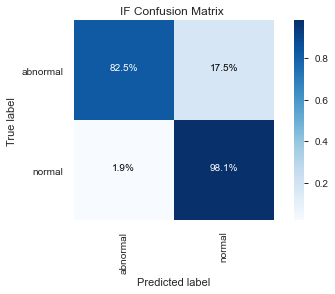

In [42]:
#y_pred_train = np.where(y_pred_train == -1,1,0)
print(classification_report(y_train_sa, y_pred_train,target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sa, y_pred_train)))
cm = confusion_matrix(y_train_sa, y_pred_train)
plot_confusion_matrix(cm, title="IF Confusion Matrix ", save=True, saveas="IF.png")

In [45]:
c1 = RdBu3[2]
c2 = RdBu3[0]
a['V1']=a['V1'].astype('int')
alloutput = a.groupby(['V1','target'])['IF_Score'].mean()
output =  alloutput.reset_index()

source = ColumnDataSource(
            data=dict(
            x=output['V1'],
            y=output['IF_Score'],
            desc=output['target'],
            color=[c1]*4+[c2]*16))

hover = HoverTool(
        tooltips=[
            ("index","$index"),
            ("(x,y)","($x,$y)"),
            ("desc","@desc")
        ])

p = figure(plot_width=600,plot_height=600,tools=[hover],title='IF Anomaly Scores for Credit Card Fraud')
p.circle('x','y', size=20,color='color',source=source)
p.line(x=range(0,max(output['V1'])),y=[0]*len(output['V1']),color='black')
p.add_tools(SaveTool())

show(p)

#### RESULTS OF LOF

              precision    recall  f1-score   support

     anomaly       0.01      0.47      0.01       315
      normal       1.00      0.85      0.92    190505

    accuracy                           0.85    190820
   macro avg       0.50      0.66      0.46    190820
weighted avg       1.00      0.85      0.92    190820

AUC:  66.0%


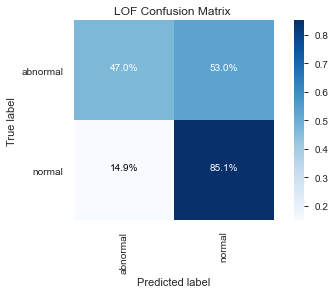

In [17]:
#y_pred_train_lof = np.where(y_pred_train_lof == -1,1,0)
print(classification_report(y_train_sa, y_pred_train_lof, target_names=['anomaly', 'normal']))
print ("AUC: ", "{:.1%}".format(roc_auc_score(y_train_sa, y_pred_train_lof)))
cm = confusion_matrix(y_train_sa, y_pred_train_lof)
plot_confusion_matrix(cm, title="LOF Confusion Matrix ")

In [18]:
c1 = RdBu3[2]
c2 = RdBu3[0]
a['V1']=a['V1'].astype('int')
alloutput = a.groupby(['V1','Class'])['LOF_Score'].mean()
output =  alloutput.reset_index()

source = ColumnDataSource(
            data=dict(
            x=output['V1'],
            y=output['LOF_Score'],
            desc=output['Class'],
            color=[c1]*4+[c2]*16))

hover = HoverTool(
        tooltips=[
            ("index","$index"),
            ("(x,y)","($x,$y)"),
            ("desc","@desc")
        ])

p = figure(plot_width=600,plot_height=600,tools=[hover],title='LOF Anomaly Scores for Credit Card Fraud')
p.circle('x','y', size=20,color='color',source=source)
p.line(x=range(0,max(output['V1'])),y=[0]*len(output['V1']),color='black')
p.add_tools(SaveTool())

show(p)

# END